In [10]:
import numpy as np
import tensorflow as tf
import pennylane as qml
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Create results directory
results_dir = "quantum_contrastive_results"
os.makedirs(results_dir, exist_ok=True)

# Load and preprocess MNIST dataset (using 7x7 downsampled version for simplicity)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Downsample to 7x7
x_train_small = np.array([np.array(tf.image.resize(img[..., np.newaxis]/255.0, (7, 7))[:,:,0]) for img in x_train])
x_test_small = np.array([np.array(tf.image.resize(img[..., np.newaxis]/255.0, (7, 7))[:,:,0]) for img in x_test])

# Flatten images
x_train_flat = x_train_small.reshape(-1, 49)
x_test_flat = x_test_small.reshape(-1, 49)

print(f"Loaded MNIST, downsampled to 7x7: Training {x_train_flat.shape}, Test {x_test_flat.shape}")

Loaded MNIST, downsampled to 7x7: Training (60000, 49), Test (10000, 49)


In [ ]:
# Number of qubits
n_qubits = 4  

# Create a quantum device
dev = qml.device("default.qubit", wires=n_qubits)

# Create a parameterized quantum circuit
@qml.qnode(dev)
def quantum_circuit(x, params):
    # Normalize and select first n_qubits features
    x_selected = x[:n_qubits]
    x_norm = np.linalg.norm(x_selected)
    if x_norm > 1e-10:  # Avoid division by zero
        x_selected = x_selected / x_norm
    
    # Encode data
    for i in range(n_qubits):
        qml.RY(np.pi * x_selected[i], wires=i)
    
    # Apply variational layers
    for layer in range(params.shape[0]):
        # Rotation gates
        for i in range(n_qubits):
            qml.RX(params[layer, i, 0], wires=i)
            qml.RY(params[layer, i, 1], wires=i)
        
        # Entanglement
        for i in range(n_qubits-1):
            qml.CNOT(wires=[i, i+1])
    
    # Measure in Z basis
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Initialize parameters (2 layers)
np.random.seed(42)
n_layers = 2
params = np.random.uniform(0, 2*np.pi, (n_layers, n_qubits, 2))

# Test the circuit
test_img = x_train_flat[0]
results = quantum_circuit(test_img, params)
print(f"Circuit test results: {results}")

Circuit test results: [tensor(-0.13432715, requires_grad=True), tensor(0.72953077, requires_grad=True), tensor(0.25963533, requires_grad=True), tensor(0.33022646, requires_grad=True)]


In [ ]:
# Define quantum device with more qubits
n_qubits = 6  # Increase for better expressivity
dev = qml.device("default.qubit", wires=n_qubits)

# Create a completely redesigned circuit with better discrimination
@qml.qnode(dev)
def quantum_circuit(x, params):

    selected_indices = [16, 18, 22, 26, 30, 32]  # Strategic positions in a 7x7 image
    features = np.array([x[i] for i in selected_indices])
    
    features = np.clip(features, 0, 1)  # Ensure in range [0,1]

    for i in range(n_qubits):
        # Scale to [0, pi] - important for discrimination
        qml.RY(np.pi * features[i], wires=i)
    
    # First entanglement layer
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    
    # Strongly parameterized rotation layer
    for layer in range(params.shape[0]):
        # Apply all 3 rotations for full Bloch sphere coverage
        for i in range(n_qubits):
            qml.RX(params[layer, i, 0], wires=i)
            qml.RY(params[layer, i, 1], wires=i)
            qml.RZ(params[layer, i, 2], wires=i)

        if layer % 2 == 0:
            for i in range(n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            # Periodic boundary
            qml.CNOT(wires=[n_qubits - 1, 0])
        # Odd layer: long-range connections
        else:
            for i in range(n_qubits // 2):
                qml.CNOT(wires=[i, i + n_qubits // 2])
    
    # Final rotation layer
    for i in range(n_qubits):
        qml.RY(params[-1, i, 0], wires=i)
    
    # Multi-basis measurement (crucial for discrimination)
    # First half: Z basis, Second half: X basis
    z_measurements = [qml.expval(qml.PauliZ(i)) for i in range(n_qubits // 2)]
    x_measurements = [qml.expval(qml.PauliX(i)) for i in range(n_qubits // 2, n_qubits)]
    
    return z_measurements + x_measurements

# Initialize parameters more strategically
np.random.seed(42)
n_layers = 3  
params = np.random.uniform(0, 2*np.pi, (n_layers + 1, n_qubits, 3))

# Test the circuit
test_img = x_train_flat[0]
test_results = quantum_circuit(test_img, params)
print(f"Circuit test results: {test_results}")
print(f"Output dimension: {len(test_results)}")

Circuit test results: [tensor(0.00805131, requires_grad=True), tensor(-0.08258635, requires_grad=True), tensor(0.12014474, requires_grad=True), tensor(0.19674469, requires_grad=True), tensor(0.00796903, requires_grad=True), tensor(0.14140367, requires_grad=True)]
Output dimension: 6


In [ ]:
def create_training_pairs(x, y, pairs_per_class=10):

    same_pairs = []
    diff_pairs = []
    
    # Create same-class pairs
    for digit in range(10):
        indices = np.where(y == digit)[0]
        if len(indices) >= 2:
            for _ in range(min(pairs_per_class, len(indices))):
                idx1, idx2 = np.random.choice(indices, 2, replace=False)
                same_pairs.append((x[idx1], x[idx2], 1))  # 1 = same class
    
    # Create different-class pairs
    for _ in range(len(same_pairs)):
        cls1, cls2 = np.random.choice(10, 2, replace=False)
        idx1 = np.random.choice(np.where(y == cls1)[0])
        idx2 = np.random.choice(np.where(y == cls2)[0])
        diff_pairs.append((x[idx1], x[idx2], 0))  # 0 = different class
    
    print(f"Created {len(same_pairs)} same-class pairs and {len(diff_pairs)} different-class pairs")
    return same_pairs, diff_pairs

# Create training pairs
same_pairs, diff_pairs = create_training_pairs(x_train_flat, y_train, pairs_per_class=20)

Created 200 same-class pairs and 200 different-class pairs


Starting training for 20 epochs...
Epoch 1/20, Loss: 0.2176, LR: 0.10000, Time: 0:01:23.988573
  Avg similarities - Same class: 0.6177, Different class: 0.5279
Epoch 2/20, Loss: 0.2164, LR: 0.10000, Time: 0:02:47.713137
  Avg similarities - Same class: 0.6056, Different class: 0.4965
Epoch 4/20, Loss: 0.2180, LR: 0.10000, Time: 0:05:35.100793
  Avg similarities - Same class: 0.6312, Different class: 0.4857
Epoch 6/20, Loss: 0.2162, LR: 0.08000, Time: 0:08:23.296519
  Avg similarities - Same class: 0.5929, Different class: 0.5082
Epoch 8/20, Loss: 0.2152, LR: 0.08000, Time: 0:11:14.309037
  Avg similarities - Same class: 0.6049, Different class: 0.5155
Epoch 10/20, Loss: 0.2006, LR: 0.08000, Time: 0:14:03.894328
  Avg similarities - Same class: 0.5824, Different class: 0.4654
Epoch 12/20, Loss: 0.1888, LR: 0.06400, Time: 0:16:54.846093
  Avg similarities - Same class: 0.6319, Different class: 0.4796
Epoch 14/20, Loss: 0.1770, LR: 0.06400, Time: 0:19:44.192778
  Avg similarities - Same c

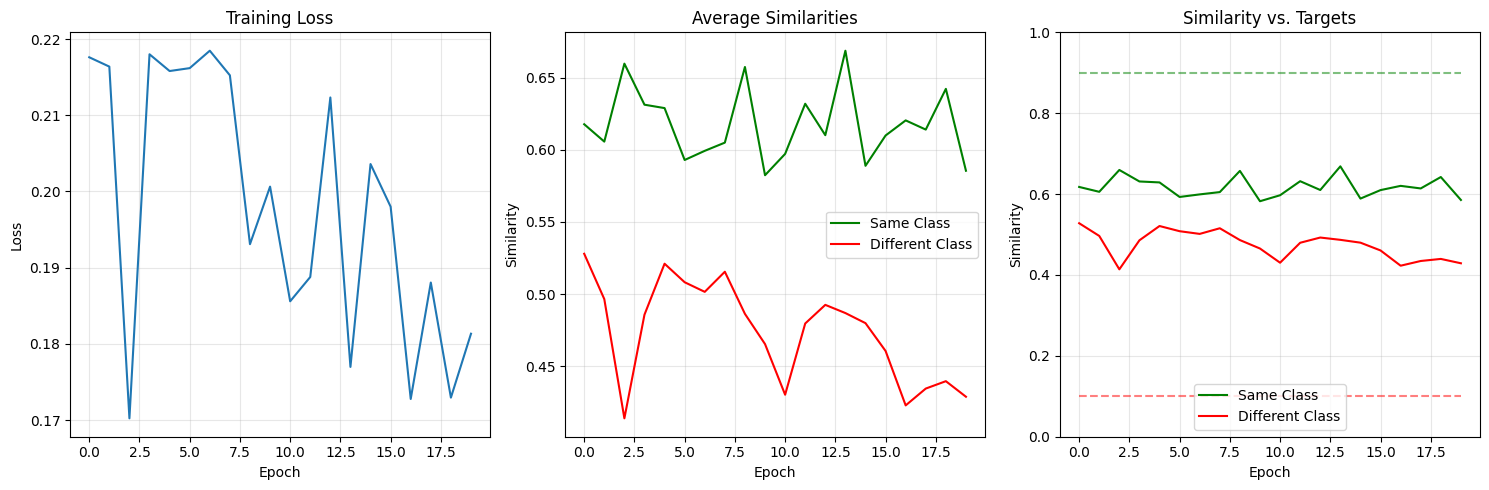

In [ ]:
def train_embedding(parameters, same_pairs, diff_pairs, n_epochs=20, learning_rate=0.1):

    # Copy the parameters
    params = parameters.copy()
    
    # Training history
    losses = []
    same_sim_history = []
    diff_sim_history = []
    
    # Flatten parameters for gradient updates
    orig_shape = params.shape
    flat_params = params.flatten()
    
    print(f"Starting training for {n_epochs} epochs...")
    start_time = datetime.now()
    
    # Learning rate scheduler (start high, then decrease)
    def get_lr(epoch):
        return learning_rate * (0.8 ** (epoch // 5))
    
    for epoch in range(n_epochs):
        # Current learning rate
        current_lr = get_lr(epoch)
        
        # Combine and shuffle pairs
        all_pairs = same_pairs + diff_pairs
        np.random.shuffle(all_pairs)
        
        epoch_loss = 0
        epoch_same_sim = 0
        epoch_diff_sim = 0
        same_count = 0
        diff_count = 0
        
        # Process all pairs
        for img1, img2, label in all_pairs[:100]:  # Process more pairs per epoch
            # Forward pass: compute similarity
            similarity = compute_similarity(img1, img2, params.reshape(orig_shape))
            
            # Compute loss gradient manually for each parameter
            gradient = np.zeros_like(flat_params)
            
            epsilon = 0.005
            
            param_indices = np.random.choice(len(flat_params), size=min(30, len(flat_params)), replace=False)
            
            for i in param_indices:
                # Create parameter variations
                params_plus = flat_params.copy()
                params_plus[i] += epsilon
                
                params_minus = flat_params.copy()
                params_minus[i] -= epsilon
                
                # Compute similarities with varied parameters
                sim_plus = compute_similarity(img1, img2, params_plus.reshape(orig_shape))
                sim_minus = compute_similarity(img1, img2, params_minus.reshape(orig_shape))
                
                # Estimate gradient with margin-based approach
                if label == 1:  # Same class: maximize similarity
                    if similarity < 0.9:
                        gradient[i] = (sim_plus - sim_minus) / (2 * epsilon)
                    else:
                        gradient[i] = 0  # Already good enough
                else:  # Different class: minimize similarity
                    if similarity > 0.1:
                        gradient[i] = -(sim_plus - sim_minus) / (2 * epsilon)
                    else:
                        gradient[i] = 0  # Already good enough
            
            # Apply gradient normalization to avoid exploding gradients
            grad_norm = np.linalg.norm(gradient)
            if grad_norm > 1.0:
                gradient = gradient / grad_norm
            
            # Update parameters with current learning rate
            flat_params += current_lr * gradient
            
            # Reshape parameters
            params = flat_params.reshape(orig_shape)
            
            # Compute loss with margin
            if label == 1:  # Same class: want similarity close to 1
                loss = max(0, 1 - similarity)**2
                epoch_same_sim += similarity
                same_count += 1
            else:  # Different class: want similarity close to 0
                loss = max(0, similarity - 0.1)**2
                epoch_diff_sim += similarity
                diff_count += 1
            
            epoch_loss += loss
        
        # Average loss and similarities
        epoch_loss /= len(all_pairs[:100])
        epoch_same_sim = epoch_same_sim / max(1, same_count)
        epoch_diff_sim = epoch_diff_sim / max(1, diff_count)
        
        losses.append(epoch_loss)
        same_sim_history.append(epoch_same_sim)
        diff_sim_history.append(epoch_diff_sim)
        
        # Print progress
        if (epoch + 1) % 2 == 0 or epoch == 0:
            elapsed = datetime.now() - start_time
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}, LR: {current_lr:.5f}, Time: {elapsed}")
            print(f"  Avg similarities - Same class: {epoch_same_sim:.4f}, Different class: {epoch_diff_sim:.4f}")
    
    # Plot training metrics
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.plot(same_sim_history, 'g-', label='Same Class')
    plt.plot(diff_sim_history, 'r-', label='Different Class')
    plt.title('Average Similarities')
    plt.xlabel('Epoch')
    plt.ylabel('Similarity')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.plot(same_sim_history, 'g-', label='Same Class')
    plt.plot([0, n_epochs-1], [0.9, 0.9], 'g--', alpha=0.5)
    plt.plot(diff_sim_history, 'r-', label='Different Class')
    plt.plot([0, n_epochs-1], [0.1, 0.1], 'r--', alpha=0.5)
    plt.title('Similarity vs. Targets')
    plt.xlabel('Epoch')
    plt.ylabel('Similarity')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{results_dir}/training_metrics.png")
    plt.show()
    
    return params, losses, same_sim_history, diff_sim_history

# Train the embedding with improved parameters
trained_params, loss_history, same_sim_history, diff_sim_history = train_embedding(
    params, 
    same_pairs, 
    diff_pairs, 
    n_epochs=20, 
    learning_rate=0.1
)

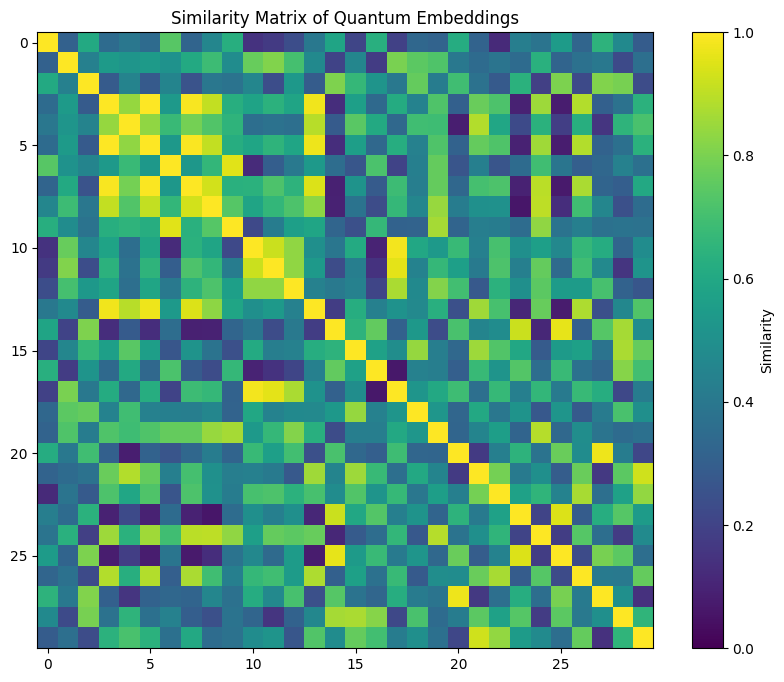

In [ ]:
def evaluate_embeddings(parameters, x_test, y_test, n_samples=5):
    # Select samples
    selected_indices = []
    selected_labels = []
    
    for digit in range(10):
        indices = np.where(y_test == digit)[0][:n_samples]
        selected_indices.extend(indices)
        selected_labels.extend([digit] * len(indices))
    
    selected_indices = np.array(selected_indices)
    selected_labels = np.array(selected_labels)
    
    # Compute similarity matrix
    n = len(selected_indices)
    similarity_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i, n):
            img1 = x_test[selected_indices[i]]
            img2 = x_test[selected_indices[j]]
            sim = compute_similarity(img1, img2, parameters)
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim  # Symmetric
    
    # Plot similarity matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(similarity_matrix, cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(label='Similarity')
    plt.title('Similarity Matrix of Quantum Embeddings')
    plt.grid(False)
    plt.savefig(f"{results_dir}/similarity_matrix.png")
    plt.show()
    
    return similarity_matrix, selected_labels

similarity_matrix, labels = evaluate_embeddings(trained_params, x_test_flat, y_test, n_samples=3)

Computing embeddings for training data...
Computing embeddings for test data...
Classifying 50 test samples...
Processed 10/50 test samples...
Processed 20/50 test samples...
Processed 30/50 test samples...
Processed 40/50 test samples...
Processed 50/50 test samples...
k-NN classification accuracy (k=3): 0.2800
k-NN accuracy with k=1: 0.3000
k-NN accuracy with k=3: 0.2800
k-NN accuracy with k=5: 0.3200
k-NN accuracy with k=7: 0.3200


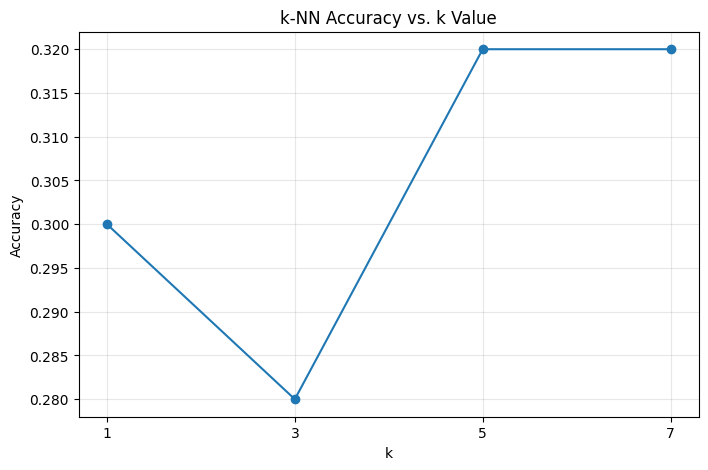

In [18]:
def knn_classify(parameters, x_train, y_train, x_test, y_test, k=3, n_samples=50):
    """
    Perform k-NN classification using quantum embeddings with improved strategy.
    
    Args:
        parameters: Circuit parameters
        x_train: Training images
        y_train: Training labels
        x_test: Test images
        y_test: Test labels
        k: Number of neighbors
        n_samples: Number of test samples
        
    Returns:
        Classification accuracy
    """
    # Select balanced subset of training data (more samples per class)
    train_indices = []
    for digit in range(10):
        indices = np.where(y_train == digit)[0][:15]  # 15 samples per class
        train_indices.extend(indices)
    
    train_indices = np.array(train_indices)
    train_x = x_train[train_indices]
    train_y = y_train[train_indices]
    
    # Select random test samples (stratified by class)
    test_indices = []
    for digit in range(10):
        digit_indices = np.where(y_test == digit)[0]
        selected = np.random.choice(digit_indices, size=min(n_samples//10, len(digit_indices)), replace=False)
        test_indices.extend(selected)
    
    test_indices = np.array(test_indices)
    test_x = x_test[test_indices]
    test_y = y_test[test_indices]
    
    # Compute all embeddings in advance
    print("Computing embeddings for training data...")
    train_embeddings = []
    for img in train_x:
        emb = np.array(quantum_circuit(img, parameters))
        train_embeddings.append(emb)
    
    print("Computing embeddings for test data...")
    test_embeddings = []
    for img in test_x:
        emb = np.array(quantum_circuit(img, parameters))
        test_embeddings.append(emb)
    
    # Classification with weighted k-NN
    correct = 0
    print(f"Classifying {len(test_x)} test samples...")
    
    for i in range(len(test_embeddings)):
        similarities = []
        
        # Compute similarity to all training samples using embeddings
        for j in range(len(train_embeddings)):
            # Compute cosine similarity directly on embeddings
            emb1 = test_embeddings[i]
            emb2 = train_embeddings[j]
            
            dot_product = np.sum(emb1 * emb2)
            norm1 = np.linalg.norm(emb1)
            norm2 = np.linalg.norm(emb2)
            
            if norm1 > 1e-10 and norm2 > 1e-10:
                # Scaled cosine similarity [0,1]
                sim = (dot_product / (norm1 * norm2) + 1) / 2
            else:
                sim = 0.5
            
            similarities.append(sim)
        
        # Find top k neighbors
        similarities = np.array(similarities)
        top_indices = np.argsort(similarities)[-k:]
        top_labels = train_y[top_indices]
        top_similarities = similarities[top_indices]
        
        # Weighted voting (weight by similarity)
        votes = np.zeros(10)
        for idx, label in enumerate(top_labels):
            votes[label] += top_similarities[idx]
        
        # Predict by highest weighted vote
        prediction = np.argmax(votes)
        
        if prediction == test_y[i]:
            correct += 1
        
        # Print progress
        if (i + 1) % 10 == 0:
            print(f"Processed {i+1}/{len(test_x)} test samples...")
    
    accuracy = correct / len(test_x)
    print(f"k-NN classification accuracy (k={k}): {accuracy:.4f}")
    
    # Try different k values
    k_values = [1, 3, 5, 7]
    accuracies = []
    
    for k_val in k_values:
        correct = 0
        for i in range(len(test_embeddings)):
            similarities = np.array([
                (np.sum(test_embeddings[i] * train_embeddings[j]) / 
                (np.linalg.norm(test_embeddings[i]) * np.linalg.norm(train_embeddings[j])) + 1) / 2
                for j in range(len(train_embeddings))
            ])
            
            top_indices = np.argsort(similarities)[-k_val:]
            top_labels = train_y[top_indices]
            top_similarities = similarities[top_indices]
            
            votes = np.zeros(10)
            for idx, label in enumerate(top_labels):
                votes[label] += top_similarities[idx]
            
            prediction = np.argmax(votes)
            
            if prediction == test_y[i]:
                correct += 1
        
        k_accuracy = correct / len(test_x)
        accuracies.append(k_accuracy)
        print(f"k-NN accuracy with k={k_val}: {k_accuracy:.4f}")
    
    # Plot accuracy vs k
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, accuracies, 'o-')
    plt.title('k-NN Accuracy vs. k Value')
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.xticks(k_values)
    plt.grid(True, alpha=0.3)
    plt.savefig(f"{results_dir}/knn_accuracy_vs_k.png")
    plt.show()
    
    return max(accuracies)

# Perform improved classification
knn_accuracy = knn_classify(
    trained_params,
    x_train_flat,
    y_train,
    x_test_flat,
    y_test,
    k=3,
    n_samples=50  # More test samples
)

The results are not satisfactory, probably because the qbit number and NN size and training batches are all not ideal.